# Quantization of difference between 3D protein structures

In this project, we focus on quantitative representation of difference between a pair of protein structures. 

### Prerequisites

1. Mapping from isoforms(RNA) to proteins(Sequence) is a bijection.  

2. Mapping from gene to isoform is one-to-many. 

3. Any two pair of isoforms transcribed by the same genome will have overlaps among sequences of their proteins. 

### What we need

1. A map from gene -> isoforms -> proteins -> atoms 

2. A map from gene -> exon -> length of the exon (is this number of atoms?)

### Algorithm for technique 1

1. Given sequencing of two proteins (say P<sub>1</sub> and P<sub>2</sub>) which have originated from a single genome, say G.

2. For each protein, say P<sup>(1)</sup>, we have a sequence of amino acids a<sup>(1)</sup><sub>1</sub>, a<sup>(1)</sup><sub>2</sub>, .... a<sup>(1)</sup><sub>n</sub> where n is the length of the protein.

3. We predict structures of the proteins using alphafold2 such that P<sup>(1)</sup><sub>i</sub> are the co-ordinates of a<sup>(1)</sup><sub>i</sub>. 

4. Let us say that proteins P<sup>(1)</sup> and P<sup>(2)</sup> correspond to isoforms I<sup>(1)</sup> and I<sup>(2)</sup>. (Note that : I<sup>(1)</sup> and I<sup>(2)</sup> must be transcribed by the source genome G). 

5. We find the exons shared by I<sup>(1)</sup> and I<sup>(2)</sup>. Then by using the lengths of the exons i.e. number of amino acids in each exon, we find overlapping runs between P<sup>(1)</sup> and P<sup>(2)</sup>. 

6. Thus, we get k overlaps L<sub>1</sub>, L<sub>2</sub>, .... L<sub>k</sub> where each lap L<sub>i</sub> stores starting and ending indices of the overlaps in each protein. I.e. L<sub>i</sub> is represented as tuple of size 4 (i<sub>1</sub>, i<sub>2</sub>, j<sub>1</sub>, j<sub>2</sub>) such that i<sub>2</sub> - i<sub>1</sub> == j<sub>2</sub> - i<sub>1</sub> and a<sup>(1)</sup><sub>i<sub>1</sub> + x </sub> == a<sup>(2)</sup><sub>j<sub>1</sub> + x </sub> for x = 0, 1, ... j<sub>2</sub> - j<sub>1</sub>. 

8. Given an overlapping run for a protein, say a<sup>(1)</sup><sub>i<sub>1</sub></sub> to a<sup>(1)</sup><sub>i<sub>2</sub></sub>, we find distance between each pair of the amino acids to form a symmetric matrix D<sup>(1)</sup><sub>1</sub> such that D<sup>(1)</sup><sub>1</sub>[i][j] = ||a<sup>(1)</sup><sub>i</sub> - a<sup>(1)</sup><sub>j</sub>|| for i, j in {i<sub>1</sub>, .... i<sub>2</sub>}. 

9. Given all such matrices, say D<sup>(1)</sup><sub>1</sub>, D<sup>(1)</sup><sub>2</sub>, ...... D<sup>(1)</sup><sub>m</sub> for P<sub>1</sub> and D<sup>(2)</sup><sub>1</sub>, D<sup>(2)</sup><sub>2</sub>, ...... D<sup>(2)</sup><sub>m</sub> for P<sub>2</sub>, we find sum of norms of differences i.e. ||D<sup>(1)</sup><sub>i</sub> - D<sup>(2)</sup><sub>i</sub>||<sub>F</sub>. 

In [1]:
from Bio import pairwise2, SeqIO
from Bio.PDB import PDBParser
from itertools import *
import json
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
from termcolor import colored
from utils import *

In [2]:
root = '/Users/aasavarikakne/Desktop/cme291/'

protein1_path = root + 'prediction_PKM1/'
protein2_path = root + 'prediction_PKM2/'

In [3]:
# step 1 : read protein sequences from local storage
seq1 = str(SeqIO.read(protein1_path + 'PKM1.fasta', "fasta").seq)
seq2 = str(SeqIO.read(protein2_path + 'PKM2.fasta', "fasta").seq)

for i, seq in enumerate([seq1, seq2]):
    print("Sequence {} has {} amino acids.".format(i+1, len(seq)))

Sequence 1 has 531 amino acids.
Sequence 2 has 531 amino acids.


In [4]:
# step 2 : get overlap using biopython
alignment = max(pairwise2.align.globalxx(seq1, seq2))

print("Alignment starts at {} and ends at {}.".format(alignment.start, alignment.end))

Alignment starts at 0 and ends at 546.


In [5]:
# debugging
x1 = alignment.seqA
x2 = alignment.seqB
s = alignment.start
e = alignment.end

for i in range(s, e, 50):
    print(colored("{} : {}".format(i//50, x1[i:i+50]), 'blue'))
    print(colored("{} : {}".format(i//50, x2[i:i+50]), 'cyan'))
    print('-'*80)

0 : MSKPHSEAGTAFIQTQQLHAAMADTFLEHMCRLDIDSPPITARNTGIICT
0 : MSKPHSEAGTAFIQTQQLHAAMADTFLEHMCRLDIDSPPITARNTGIICT
--------------------------------------------------------------------------------
1 : IGPASRSVETLKEMIKSGMNVARLNFSHGTHEYHAETIKNVRTATESFAS
1 : IGPASRSVETLKEMIKSGMNVARLNFSHGTHEYHAETIKNVRTATESFAS
--------------------------------------------------------------------------------
2 : DPILYRPVAVALDTKGPEIRTGLIKGSGTAEVELKKGATLKITLDNAYME
2 : DPILYRPVAVALDTKGPEIRTGLIKGSGTAEVELKKGATLKITLDNAYME
--------------------------------------------------------------------------------
3 : KCDENILWLDYKNICKVVEVGSKIYVDDGLISLQVKQKGADFLVTEVENG
3 : KCDENILWLDYKNICKVVEVGSKIYVDDGLISLQVKQKGADFLVTEVENG
--------------------------------------------------------------------------------
4 : GSLGSKKGVNLPGAAVDLPAVSEKDIQDLKFGVEQDVDMVFASFIRKASD
4 : GSLGSKKGVNLPGAAVDLPAVSEKDIQDLKFGVEQDVDMVFASFIRKASD
--------------------------------------------------------------------------------
5 : VHEVRKVLGEKGKNIKIISKIENHEGVRRFDEILEASDGIM

In [6]:
# step 3 : map alignment indices to sequence indices
map1 = get_index_map(alignment.seqA)
map2 = get_index_map(alignment.seqB)

In [7]:
# step 4 : group the aligned residues together 
overlaps = get_overlaps(alignment)

In [8]:
for s, e in overlaps:
    a = seq1[map1[s] : map1[e] + 1]
    b = seq2[map2[s] : map2[e] + 1]
    length = e - s + 1
    for j in range(length):
        if a[j] != b[j]:
            print(s + j)

In [9]:
# step 5 : read output from alphafold, get positioning for each atom inside each residue
parser = PDBParser(PERMISSIVE = True, QUIET = True) 

data1 = parser.get_structure("2fat", protein1_path + "selected_prediction.pdb")
data2 = parser.get_structure("2fat", protein2_path + "selected_prediction.pdb")

residues1 = get_residues(data1)
residues2 = get_residues(data2)

In [15]:
def get_positions_for_overlap(residues, start, end):
    positions = []
    for i in range(start, end + 1):
        for atom in residues[i].get_atoms():
            p = atom.get_vector().get_array()
            positions.append(p) 
    positions = np.stack(positions, axis=0) if positions else None
    return positions

In [31]:
# step 6 : for each overlap, get the positioning all atoms in the overlap for each protein
y = []
x = []

for s, e in overlaps:
    # m amino acid 
    x.append(e - s + 1)
    
    p1 = get_position_for_overlap(residues1, map1[s], map1[e]) # n x 3
    p2 = get_position_for_overlap(residues2, map2[s], map2[e]) # n x 3

    D1 = get_dist_mat(p1) # D1[i, j] = || p1[i] - p1[j] || 
    D2 = get_dist_mat(p2)
    n = p1.shape[0]

    y.append(np.linalg.norm(D1 - D2))

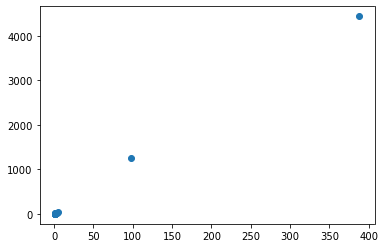

In [32]:
import matplotlib.pyplot as plt
plt.scatter(x, y)

In [ ]:
# what does it mean to have a different structure ?
# if two proteins have similar structure, how different structures should they have?
# can we label proteins to be used in supervised learning -> domains ?
# If p1 and p2 are similar in structure, will they have same function?
# mutations in the genome are harmful
# hypothesis testing
# significance doesn't imply biological significance
# size effect -> how large n is 


# what is in the alphafold error file 
# sherlock 
# .gtf files -> code

# permutation testing / bootstrap

# paper that compare protein structures or functions
# procrustes